In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to C:\Users\rifat
[nltk_data]     syarief\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\rifat
[nltk_data]     syarief\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\rifat
[nltk_data]     syarief\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
pmd = pd.read_csv('nh_h_all.csv')
pmd.columns = ['text', 'label']  # Ubah nama kolom biar lebih enak digunakan
pmd

text  label
0      some of the group of boys teases my sister whi...      1
1      but the vote also exposed mechanical problems ...      0
2      these adjustments will enable more focused lea...      0
3      i was forced to have sex with a cousin we were...      1
4      rico is a powerful weapon for bringing togethe...      0
...                                                  ...    ...
24614  om sai beach huts is not safe for female solo ...      1
24615  this incident took place in morning at sector ...      1
24616  led zeppelin did not steal the opening riff of...      0
24617  i was passing by and then some men started cal...      1
24618  joe dopp and chelsie brown said being homeless...      0

[24619 rows x 2 columns]

In [3]:
pmd['char_length'] = pmd['text'].astype(str).apply(len)
pmd['word_count'] = pmd['text'].astype(str).apply(lambda x: len(x.split()))
pmd['unique_words'] = pmd['text'].astype(str).apply(lambda x: len(set(x.split())))
pmd['lexical_diversity'] = pmd['unique_words'] / pmd['word_count'].replace(0, 1)  # hindari pembagian dengan nol
pmd

text  label  char_length  \
0      some of the group of boys teases my sister whi...      1           80   
1      but the vote also exposed mechanical problems ...      0          162   
2      these adjustments will enable more focused lea...      0          156   
3      i was forced to have sex with a cousin we were...      1          129   
4      rico is a powerful weapon for bringing togethe...      0          340   
...                                                  ...    ...          ...   
24614  om sai beach huts is not safe for female solo ...      1          909   
24615  this incident took place in morning at sector ...      1          142   
24616  led zeppelin did not steal the opening riff of...      0          196   
24617  i was passing by and then some men started cal...      1           81   
24618  joe dopp and chelsie brown said being homeless...      0           85   

       word_count  unique_words  lexical_diversity  
0              15            14           0.933333  
1              26            24           0.923077  
2              21            21           1.000000  
3              28            26           0.928571  
4              58            50           0.862069  
...           ...           ...                ...  
24614         176           101           0.573864  
24615          28            26           0.928571  
24616          37            32           0.864865  
24617          16            14           0.875000  
24618          15            15           1.000000  

[24619 rows x 6 columns]

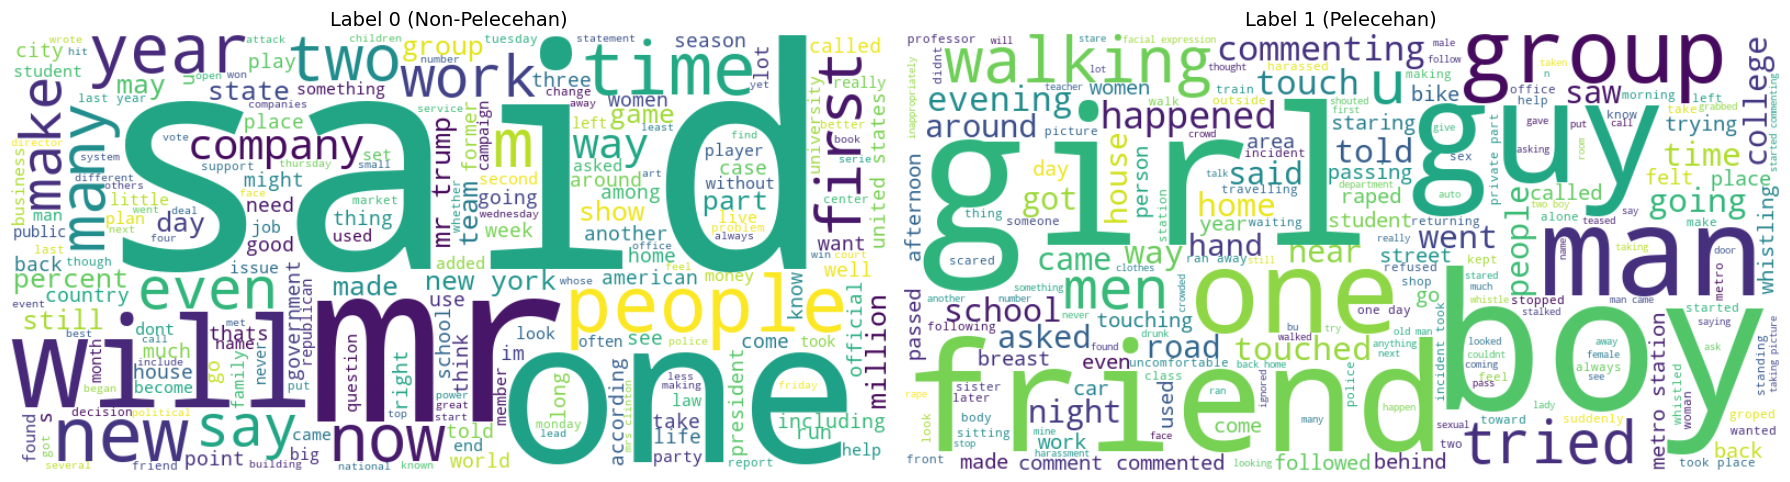

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# WordCloud per label tanpa colormap
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
labels = [0, 1]
titles = ['Label 0 (Non-Pelecehan)', 'Label 1 (Pelecehan)']

for i, label in enumerate(labels):
    text = ' '.join(pmd[pmd['label'] == label]['text'].astype(str))
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    axs[i].imshow(wc, interpolation='bilinear')
    axs[i].axis('off')
    axs[i].set_title(titles[i], fontsize=14)

plt.tight_layout()
plt.show()


In [5]:
from collections import Counter

all_words = ' '.join(pmd['text'].astype(str)).lower().split()
common_words = Counter(all_words).most_common(20)

pd.DataFrame(common_words, columns=['word', 'count'])


word  count
0    the  51292
1      a  27850
2    and  26806
3     to  25846
4     of  22010
5     in  20367
6    was  12694
7      i  11984
8   that  10657
9     on   9125
10   for   8576
11    he   8337
12    it   6823
13  with   6778
14    at   6756
15    is   6662
16  said   5940
17    my   5850
18    me   5831
19    as   5095

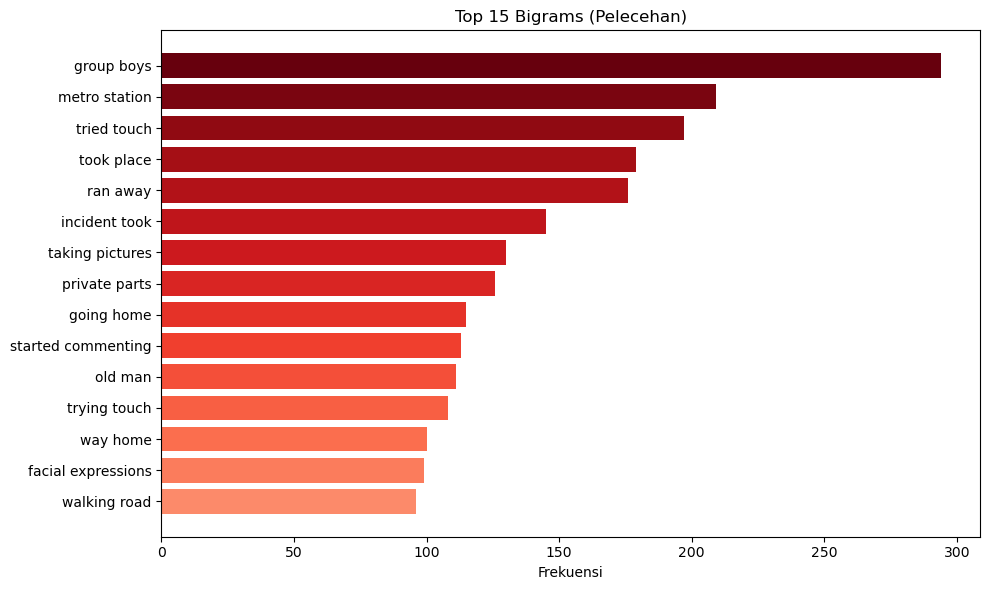

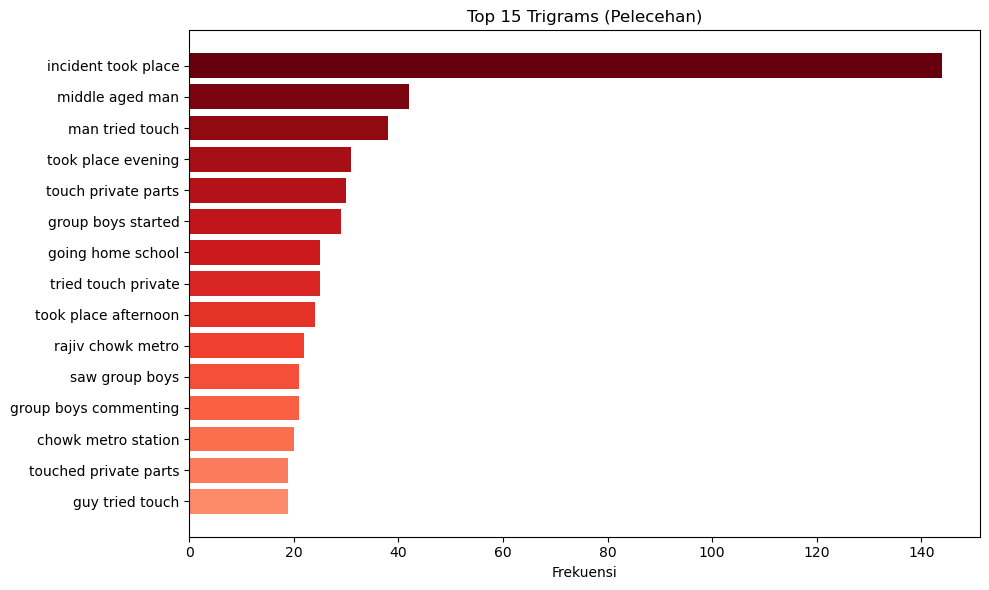

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# Fungsi ambil n-gram
def get_top_ngrams(corpus, ngram_range=(2,2), n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bow = vec.transform(corpus)
    sum_words = bow.sum(axis=0)
    words_freq = sorted([(w, sum_words[0, i]) for w, i in vec.vocabulary_.items()],
                        key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Fungsi plot dengan gradasi merah (semakin ke atas makin pekat)
def plot_top_words(top_words, title):
    words, counts = zip(*top_words)
    # Gradasi merah dibalik urutannya
    colors = plt.cm.Reds(np.linspace(1, 0.4, len(words)))  # urutan dibalik
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(words)), counts, color=colors)
    plt.yticks(range(len(words)), words)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Frekuensi")
    plt.tight_layout()
    plt.show()

# Filter hanya data pelecehan (label = 1)
corpus_harassment = pmd[pmd['label'] == 1]['text'].astype(str)

# Tampilkan bigram & trigram pelecehan
plot_top_words(get_top_ngrams(corpus_harassment, (2,2), 15), "Top 15 Bigrams (Pelecehan)")
plot_top_words(get_top_ngrams(corpus_harassment, (3,3), 15), "Top 15 Trigrams (Pelecehan)")


In [7]:
from sklearn.model_selection import train_test_split
import pandas as pd

def split_data(df, test_size=0.2, random_state=42):
    """
    Splits the DataFrame into training and testing sets with label proportions printed.

    Args:
        df (pandas.DataFrame): Must contain 'text' and 'label' columns.
        test_size (float): Portion of data to allocate as test set.
        random_state (int): Random seed for reproducibility.

    Returns:
        tuple: X_train, X_test, y_train, y_test
    """
    X_train, X_test, y_train, y_test = None, None, None, None

    if df is None or not isinstance(df, pd.DataFrame) or 'text' not in df.columns or 'label' not in df.columns:
        print("❌ Error: Invalid DataFrame.")
        return X_train, X_test, y_train, y_test
    if df.empty:
        print("❌ Error: Empty DataFrame.")
        return X_train, X_test, y_train, y_test

    try:
        X = df['text']
        y = df['label']
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )

        print("Data split successfully:")
        print(f"  Training set size: {len(X_train)}")
        print(f"  Testing set size: {len(X_test)}")

        # Calculate and show proportions
        train_proportion = y_train.value_counts(normalize=True).reset_index()
        train_proportion.columns = ['label', 'proportion']
        print("  Training label distribution:")
        print(train_proportion.set_index('label'))

        test_proportion = y_test.value_counts(normalize=True).reset_index()
        test_proportion.columns = ['label', 'proportion']
        print("  Testing label distribution:")
        print(test_proportion.set_index('label'))

    except Exception as e:
        print(f"❌ Error during split: {e}")

    return X_train, X_test, y_train, y_test

In [8]:
df_raw = pd.read_csv('nh_h_all.csv')
df_raw.columns = ['text', 'label']  # Penyesuaian nama kolom jika perlu

X_train, X_test, y_train, y_test = split_data(df_raw)


Data split successfully:
  Training set size: 19695
  Testing set size: 4924
  Training label distribution:
       proportion
label            
0        0.675958
1        0.324042
  Testing label distribution:
       proportion
label            
0        0.676076
1        0.323924


In [9]:
len(pmd)

24619

In [10]:
pmd.isnull().sum()

text                 0
label                0
char_length          0
word_count           0
unique_words         0
lexical_diversity    0
dtype: int64

In [11]:
pmd.duplicated().sum()

84

In [12]:
pmd['lower_text'] = pmd['text'].str.lower()
pmd[['text', 'lower_text']].head()

text  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                          lower_text  
0  some of the group of boys teases my sister whi...  
1  but the vote also exposed mechanical problems ...  
2  these adjustments will enable more focused lea...  
3  i was forced to have sex with a cousin we were...  
4  rico is a powerful weapon for bringing togethe...

In [13]:
# removing digits
pmd['no_digit'] = pmd['lower_text'].str.replace(r'\d+', '', regex=True)
pmd[['text','lower_text', 'no_digit']].head()

text  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                          lower_text  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                            no_digit  
0  some of the group of boys teases my sister whi...  
1  but the vote also exposed mechanical problems ...  
2  these adjustments will enable more focused lea...  
3  i was forced to have sex with a cousin we were...  
4  rico is a powerful weapon for bringing togethe...

In [14]:
# removing digits
pmd['no_digit'] = pmd['lower_text'].str.replace(r'\d+', '', regex=True)
pmd[['text','lower_text', 'no_digit']].head()

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

pmd['no_punct_text'] = pmd['lower_text'].apply(remove_punctuation)
# Corrected the typo here from pmdpmd to pmd
pmd[['text','lower_text', 'no_digit','no_punct_text']].head()

text  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                          lower_text  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                            no_digit  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                       no_punct_text  
0  some of the group of boys teases my sister whi...  
1  but the vote also exposed mechanical problems ...  
2  these adjustments will enable more focused lea...  
3  i was forced to have sex with a cousin we were...  
4  rico is a powerful weapon for bringing togethe...

In [15]:
def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()
pmd['normalized_text'] = pmd['no_punct_text'].apply(normalize_whitespace)

# Lihat hasil
pmd[['text', 'lower_text', 'no_digit', 'no_punct_text', 'normalized_text']].head()

text  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                          lower_text  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                            no_digit  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                       no_punct_text  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                     normalized_text  
0  some of the group of boys teases my sister whi...  
1  but the vote also exposed mechanical problems ...  
2  these adjustments will enable more focused lea...  
3  i was forced to have sex with a cousin we were...  
4  rico is a powerful weapon for bringing togethe...

In [16]:
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

pmd['tokens'] = pmd['normalized_text'].apply(word_tokenize)
pmd[['text', 'lower_text', 'no_digit', 'no_punct_text', 'normalized_text', 'tokens']].head()

[nltk_data] Downloading package punkt_tab to C:\Users\rifat
[nltk_data]     syarief\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


text  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                          lower_text  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                            no_digit  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                       no_punct_text  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                     normalized_text  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                              tokens  
0  [some, of, the, group, of, boys, teases, my, s...  
1  [but, the, vote, also, exposed, mechanical, pr...  
2  [these, adjustments, will, enable, more, focus...  
3  [i, was, forced, to, have, sex, with, a, cousi...  
4  [rico, is, a, powerful, weapon, for, bringing,...

In [17]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

pmd['no_stopwords'] = pmd['tokens'].apply(lambda x: [word for word in x if word not in stop_words])
pmd[['text', 'lower_text', 'no_digit', 'no_punct_text', 'normalized_text', 'tokens','no_stopwords']].head()

[nltk_data] Downloading package stopwords to C:\Users\rifat
[nltk_data]     syarief\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


text  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                          lower_text  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                            no_digit  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                       no_punct_text  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                     normalized_text  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                              tokens  \
0  [some, of, the, group, of, boys, teases, my, s...   
1  [but, the, vote, also, exposed, mechanical, pr...   
2  [these, adjustments, will, enable, more, focus...   
3  [i, was, forced, to, have, sex, with, a, cousi...   
4  [rico, is, a, powerful, weapon, for, bringing,...   

                                        no_stopwords  
0  [group, boys, teases, sister, returning, shopp...  
1  [vote, also, exposed, mechanical, problems, el...  
2  [adjustments, enable, focused, leadership, scr...  
3  [forced, sex, cousin, palying, inserted, hands...  
4  [rico, powerful, weapon, bringing, together, s...

In [18]:
# Inisialisasi stemmer
from nltk.stem import PorterStemmer # Import PorterStemmer

stemmer = PorterStemmer()

# 7a. Stemming (Porter Stemmer)
pmd['stemmed'] = pmd['no_stopwords'].apply(lambda x: [stemmer.stem(word) for word in x])
pmd[['text', 'lower_text', 'no_digit', 'no_punct_text', 'normalized_text', 'tokens','no_stopwords','stemmed']].head()

text  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                          lower_text  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                            no_digit  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                       no_punct_text  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                     normalized_text  \
0  some of the group of boys teases my sister whi...   
1  but the vote also exposed mechanical problems ...   
2  these adjustments will enable more focused lea...   
3  i was forced to have sex with a cousin we were...   
4  rico is a powerful weapon for bringing togethe...   

                                              tokens  \
0  [some, of, the, group, of, boys, teases, my, s...   
1  [but, the, vote, also, exposed, mechanical, pr...   
2  [these, adjustments, will, enable, more, focus...   
3  [i, was, forced, to, have, sex, with, a, cousi...   
4  [rico, is, a, powerful, weapon, for, bringing,...   

                                        no_stopwords  \
0  [group, boys, teases, sister, returning, shopp...   
1  [vote, also, exposed, mechanical, problems, el...   
2  [adjustments, enable, focused, leadership, scr...   
3  [forced, sex, cousin, palying, inserted, hands...   
4  [rico, powerful, weapon, bringing, together, s...   

                                             stemmed  
0           [group, boy, teas, sister, return, shop]  
1  [vote, also, expos, mechan, problem, elector, ...  
2  [adjust, enabl, focus, leadership, screen, ope...  
3  [forc, sex, cousin, pali, insert, hand, vagina...  
4  [rico, power, weapon, bring, togeth, singl, pr...

In [19]:
# Gabungkan token stemmed jadi satu kalimat clean_text
pmd['clean_text'] = pmd['stemmed'].apply(lambda x: ' '.join(x))

# Simpan hanya kolom clean_text dan label
pmd[['clean_text', 'label']].to_csv('data_cleantext_label.csv', index=False)

In [20]:
clean=pd.read_csv('data_cleantext_label.csv')
clean

clean_text  label
0                      group boy teas sister return shop      1
1      vote also expos mechan problem elector system ...      0
2      adjust enabl focus leadership screen oper crit...      0
3      forc sex cousin pali insert hand vagina age remov      1
4      rico power weapon bring togeth singl prosecut ...      0
...                                                  ...    ...
24614  om sai beach hut safe femal solo travel owner ...      1
24615  incid took place morn sector rohini walk colle...      1
24616  led zeppelin steal open riff rock anthem stair...      0
24617                 pass men start call tell im beauti      1
24618  joe dopp chelsi brown said homeless cant help ...      0

[24619 rows x 2 columns]

# FE

In [21]:
pmd.to_csv('data_cleantext_label.csv', index=False)

In [22]:
data = pd.read_csv('data_cleantext_label.csv')
data.isnull().sum()

text                 0
label                0
char_length          0
word_count           0
unique_words         0
lexical_diversity    0
lower_text           0
no_digit             0
no_punct_text        0
normalized_text      0
tokens               0
no_stopwords         0
stemmed              0
clean_text           2
dtype: int64

In [23]:
data = data[data['clean_text'].notnull()].reset_index(drop=True)
data.isnull().sum()

text                 0
label                0
char_length          0
word_count           0
unique_words         0
lexical_diversity    0
lower_text           0
no_digit             0
no_punct_text        0
normalized_text      0
tokens               0
no_stopwords         0
stemmed              0
clean_text           0
dtype: int64

In [24]:
data['tokens'] = data['clean_text'].apply(lambda x: word_tokenize(x.lower()))

In [25]:
import math
# Cell 5: TF-IDF Implementation from Scratch
def computeTF(wordDict, doc):
    """
    tf(t,d) = count of t in d / number of words in d
    Following reference logic
    """
    tfDict = {}
    corpusCount = len(doc.split())
    for word, count in wordDict.items():
        tfDict[word] = count/float(corpusCount)
    return tfDict

def computeIDF(docList):
    """
    idf(t) = log(N/(df + 1))
    Following reference logic
    """
    idfDict = {}
    N = len(docList)

    # Get all unique words
    all_words = set(word for doc in docList for word in doc.keys())

    for word in all_words:
        # Count documents containing the word
        containing_docs = sum(1 for doc in docList if word in doc and doc[word] > 0)
        idfDict[word] = math.log10(N / (containing_docs + 1))

    return idfDict

def computeTFIDF(tfBow, idfs):
    """
    tf-idf(t, d) = tf(t, d) * idf(t)
    Following reference logic
    """
    tfidf = {}
    for word, val in tfBow.items():
        tfidf[word] = val * idfs.get(word, 0)
    return tfidf

def create_word_dict(total_words, sentence):
    """
    Create word dictionary for a sentence
    Following reference logic
    """
    wordDict = {}
    for word in sentence.split():
        wordDict[word] = wordDict.get(word, 0) + 1

    return wordDict

# Get all unique words from corpus
all_words = set()
for text in pmd['clean_text']:
    all_words.update(text.split())

all_words = list(all_words)
print(f"Total unique words: {len(all_words)}")

# Create word dictionaries for each document
word_dicts = []
for text in pmd['clean_text']:
    word_dict = create_word_dict(all_words, text)
    word_dicts.append(word_dict)

# Compute IDF
idf_dict = computeIDF(word_dicts)

# Compute TF-IDF
tfidf_documents = []
for i, text in enumerate(pmd['clean_text']):
    if not text.strip():  # Skip empty documents
        tfidf_documents.append({})
        continue
    tf_dict = computeTF(word_dicts[i], text)
    tfidf_dict = computeTFIDF(tf_dict, idf_dict)
    tfidf_documents.append(tfidf_dict)

print("TF-IDF computation completed!")

Total unique words: 31956
TF-IDF computation completed!


In [27]:
from sklearn.feature_selection import SelectKBest, chi2

# Cell 6: Feature Selection using Chi-Square
# Convert TF-IDF to matrix format
tfidf_matrix = []
for tfidf_doc in tfidf_documents:
    doc_vector = [tfidf_doc.get(word, 0) for word in all_words]
    tfidf_matrix.append(doc_vector)

X_tfidf = np.array(tfidf_matrix)
y_labels = pmd['label'].values

# Apply Chi-square feature selection (using import as specified)
K = 1000  # Select top 1000 features
chi2_selector = SelectKBest(chi2, k=K)
X_selected = chi2_selector.fit_transform(X_tfidf, y_labels)

# Get selected feature indices
selected_indices = chi2_selector.get_support(indices=True)
selected_features = [all_words[i] for i in selected_indices]

print(f"Selected {len(selected_features)} features using Chi-square")
print(f"Feature matrix shape: {X_selected.shape}")

Selected 1000 features using Chi-square
Feature matrix shape: (24619, 1000)


In [ ]:
def get_selected_feature_names_manual(all_words, selector):
    try:
        mask = selector.get_support()
        all_feature_names = np.array(all_words)
        selected_feature_names = all_feature_names[mask]
        return selected_feature_names.tolist()
    except Exception as e:
        print(f"An error occurred while getting selected feature names: {e}")
        return None



--- Inspecting Features Selected by Chi-Square ---
Number of features selected by Chi2: 1000
First 50 selected features (Chi2): ['bodi', 'brush', 'fund', 'practic', 'daylight', 'financ', 'helpless', 'nomine', 'case', 'david', 'pinch', 'cowork', 'prostitut', 'men', 'must', 'nake', 'nerul', 'trial', 'gener', 'behaviour', 'group', 'behind', 'latest', 'match', 'prosecutor', 'believ', 'effort', 'front', 'ali', 'mr', 'william', 'eve', 'made', 'crisi', 'governor', 'capit', 'harass', 'art', 'featur', 'leg', 'attack', 'around', 'compar', 'pervert', 'tempoo', 'besid', 'p', 'system', 'b', 'career']


C:\Users\rifat syarief\AppData\Local\Temp\ipykernel_17840\844713440.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='score', y='feature', data=score_df.head(30), palette="rocket")


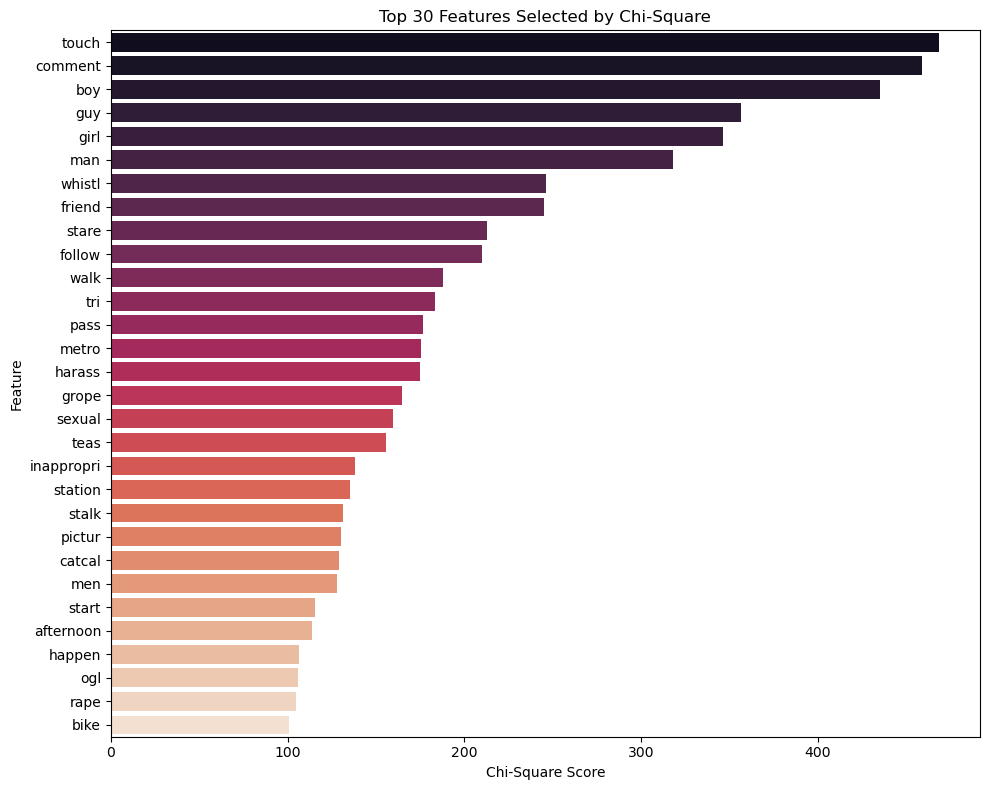

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Inspecting Features Selected by Chi-Square ---")
selected_features_chi2_names = get_selected_feature_names_manual(all_words, chi2_selector)

if selected_features_chi2_names:
    print(f"Number of features selected by Chi2: {len(selected_features_chi2_names)}")
    print(f"First 50 selected features (Chi2): {selected_features_chi2_names[:50]}")

    # Ambil skor chi2 untuk fitur yang terpilih
    scores = chi2_selector.scores_[chi2_selector.get_support()]
    
    # Buat DataFrame dan sort berdasarkan skor
    score_df = pd.DataFrame({
        'feature': selected_features_chi2_names,
        'score': scores
    }).sort_values(by='score', ascending=False)

    # Plot Top 30
    plt.figure(figsize=(10, 8))
    sns.barplot(x='score', y='feature', data=score_df.head(30), palette="rocket")
    plt.title("Top 30 Features Selected by Chi-Square")
    plt.xlabel("Chi-Square Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
else:
    print("No features were selected or an error occurred.")


In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training labels distribution: {np.bincount(y_train)}")
print(f"Test labels distribution: {np.bincount(y_test)}")

Training set shape: (19695, 1000)
Test set shape: (4924, 1000)
Training labels distribution: [13313  6382]
Test labels distribution: [3329 1595]


In [37]:
from sklearn.metrics import accuracy_score

class NaiveBayesFromScratch:
    def __init__(self, alpha=10):
        self.alpha = alpha  # Laplace smoothing parameter
        self.pi = None  # Prior probabilities
        self.word_probs = None  # Word probabilities per class
        self.classes = None
    
    def fit(self, X_train, y_train):
        self.classes = np.unique(y_train)
        n_classes = len(self.classes)
        n_features = X_train.shape[1]
        
        # Calculate priors (pi) - following reference
        class_counts = np.bincount(y_train)
        self.pi = class_counts / len(y_train)
        
        # Initialize word probabilities
        self.word_probs = {}
        
        # Calculate word probabilities for each class
        for class_idx in self.classes:
            # Get data for this class
            X_class = X_train[y_train == class_idx]
            
            # Calculate word counts for this class
            word_counts = np.sum(X_class, axis=0)
            
            # Total words in this class
            total_words = np.sum(word_counts)
            
            # Vocabulary size (number of unique words with non-zero counts)
            vocab_size = np.sum(word_counts > 0)
            
            # Apply Laplace smoothing - following reference formula
            # P(word|class) = (count + alpha) / (total_count + vocab_size + 1)
            smoothed_probs = (word_counts + self.alpha) / (total_words + vocab_size + 1)
            self.word_probs[class_idx] = smoothed_probs
        
        print(f"Training completed. Classes: {self.classes}")
        print(f"Prior probabilities: {self.pi}")
    
    def predict(self, X_test):
        predictions = []
        
        for i in range(len(X_test)):
            # Get indices of non-zero features (words present in document)
            feature_indices = np.where(X_test[i] != 0)[0]
            
            posteriors = []
            
            for class_idx in self.classes:
                # Calculate likelihood
                if len(feature_indices) > 0:
                    likelihood = np.prod(self.word_probs[class_idx][feature_indices])
                else:
                    likelihood = 1.0
                
                # Calculate posterior = likelihood * prior
                posterior = likelihood * self.pi[class_idx]
                posteriors.append(posterior)
            
            # Predict class with highest posterior
            predicted_class = self.classes[np.argmax(posteriors)]
            predictions.append(predicted_class)
        
        return np.array(predictions)

# Train Naive Bayes model
nb_model = NaiveBayesFromScratch(alpha=10)
nb_model.fit(X_train, y_train)

# Make predictions
nb_train_preds = nb_model.predict(X_train)
nb_test_preds = nb_model.predict(X_test)

# Calculate accuracies
nb_train_acc = accuracy_score(y_train, nb_train_preds)
nb_test_acc = accuracy_score(y_test, nb_test_preds)

print(f"\nNaive Bayes Results:")
print(f"Training Accuracy: {nb_train_acc:.4f}")
print(f"Test Accuracy: {nb_test_acc:.4f}")

Training completed. Classes: [0 1]
Prior probabilities: [0.67595837 0.32404163]

Naive Bayes Results:
Training Accuracy: 0.9633
Test Accuracy: 0.9626


In [38]:

# Cell 9: Random Forest from Scratch
class RandomForestFromScratch:
    def __init__(self, n_estimators=10, max_features=None, max_depth=10, min_samples_split=2):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []
        self.oob_scores = []
    
    def entropy(self, y):
        if len(y) == 0:
            return 0
        
        counts = np.bincount(y)
        probabilities = counts / len(y)
        
        entropy_val = 0
        for p in probabilities:
            if p > 0:
                entropy_val -= p * np.log2(p)
        
        return entropy_val
    
    def information_gain(self, y, y_left, y_right):
        if len(y_left) == 0 or len(y_right) == 0:
            return 0
        
        p_left = len(y_left) / len(y)
        p_right = len(y_right) / len(y)
        
        parent_entropy = self.entropy(y)
        left_entropy = self.entropy(y_left)
        right_entropy = self.entropy(y_right)
        
        weighted_entropy = p_left * left_entropy + p_right * right_entropy
        
        return parent_entropy - weighted_entropy
    
    def draw_bootstrap(self, X, y):
        n_samples = len(X)
        bootstrap_indices = np.random.choice(n_samples, n_samples, replace=True)
        oob_indices = np.array([i for i in range(n_samples) if i not in bootstrap_indices])
        
        X_bootstrap = X[bootstrap_indices]
        y_bootstrap = y[bootstrap_indices]
        
        if len(oob_indices) > 0:
            X_oob = X[oob_indices]
            y_oob = y[oob_indices]
        else:
            X_oob = np.array([])
            y_oob = np.array([])
        
        return X_bootstrap, y_bootstrap, X_oob, y_oob
    
    def find_best_split(self, X, y):
        n_features = X.shape[1]
        
        # Select random features (bagging approach)
        if self.max_features is None:
            max_features = int(np.sqrt(n_features))
        else:
            max_features = self.max_features
        
        feature_indices = np.random.choice(n_features, 
                                         min(max_features, n_features), 
                                         replace=False)
        
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        for feature_idx in feature_indices:
            feature_values = X[:, feature_idx]
            unique_values = np.unique(feature_values)
            
            for threshold in unique_values:
                left_mask = feature_values <= threshold
                right_mask = ~left_mask
                
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                
                y_left = y[left_mask]
                y_right = y[right_mask]
                
                gain = self.information_gain(y, y_left, y_right)
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gain
    
    def terminal_node(self, y):
        if len(y) == 0:
            return 0
        return np.argmax(np.bincount(y))
    
    def build_tree(self, X, y, depth=0):
        # Terminal conditions
        if (depth >= self.max_depth or 
            len(np.unique(y)) == 1 or 
            len(y) < self.min_samples_split):
            return self.terminal_node(y)
        
        # Find best split
        feature_idx, threshold, gain = self.find_best_split(X, y)
        
        if feature_idx is None or gain <= 0:
            return self.terminal_node(y)
        
        # Split data
        left_mask = X[:, feature_idx] <= threshold
        right_mask = ~left_mask
        
        # Recursively build subtrees
        left_subtree = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self.build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return {
            'feature_idx': feature_idx,
            'threshold': threshold,
            'left': left_subtree,
            'right': right_subtree
        }
    
    def predict_tree(self, tree, x):
        if not isinstance(tree, dict):
            return tree
        
        if x[tree['feature_idx']] <= tree['threshold']:
            return self.predict_tree(tree['left'], x)
        else:
            return self.predict_tree(tree['right'], x)
    
    def predict_single_tree(self, tree, X):
        return np.array([self.predict_tree(tree, x) for x in X])
    
    def fit(self, X, y):
        self.trees = []
        self.oob_scores = []
        
        for i in range(self.n_estimators):
            # Bootstrap sampling
            X_bootstrap, y_bootstrap, X_oob, y_oob = self.draw_bootstrap(X, y)
            
            # Build tree
            tree = self.build_tree(X_bootstrap, y_bootstrap)
            self.trees.append(tree)
            
            # Calculate OOB score
            if len(X_oob) > 0:
                oob_preds = self.predict_single_tree(tree, X_oob)
                oob_score = 1 - accuracy_score(y_oob, oob_preds)
                self.oob_scores.append(oob_score)
        
        if self.oob_scores:
            print(f"OOB estimate: {np.mean(self.oob_scores):.4f}")
    
    def predict(self, X):
        """
        Make predictions using ensemble following reference
        """
        tree_predictions = np.array([self.predict_single_tree(tree, X) for tree in self.trees])
        
        # Majority voting
        final_predictions = []
        for i in range(X.shape[0]):
            votes = tree_predictions[:, i]
            prediction = Counter(votes).most_common(1)[0][0]
            final_predictions.append(prediction)
        
        return np.array(final_predictions)

print("Training Random Forest...")
rf_model = RandomForestFromScratch(
    n_estimators=10,
    max_features=int(np.sqrt(X_train.shape[1])),
    max_depth=10,
    min_samples_split=2
)
rf_model.fit(X_train, y_train)

rf_train_preds = rf_model.predict(X_train)
rf_test_preds = rf_model.predict(X_test)

rf_train_acc = accuracy_score(y_train, rf_train_preds)
rf_test_acc = accuracy_score(y_test, rf_test_preds)

print(f"\nRandom Forest Results:")
print(f"Training Accuracy: {rf_train_acc:.4f}")
print(f"Test Accuracy: {rf_test_acc:.4f}")

Training Random Forest...
OOB estimate: 0.1940

Random Forest Results:
Training Accuracy: 0.8011
Test Accuracy: 0.7967


In [40]:
from sklearn.metrics import accuracy_score, classification_report

In [41]:
print("=" * 60)
print("EVALUASI MODEL")
print("=" * 60)

print("\n1. NAIVE BAYES FROM SCRATCH")
print("-" * 40)
print(f"Training Accuracy: {nb_train_acc:.4f}")
print(f"Test Accuracy: {nb_test_acc:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, nb_test_preds))

EVALUASI MODEL

1. NAIVE BAYES FROM SCRATCH
----------------------------------------
Training Accuracy: 0.9633
Test Accuracy: 0.9626

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3329
           1       0.91      0.98      0.94      1595

    accuracy                           0.96      4924
   macro avg       0.95      0.97      0.96      4924
weighted avg       0.96      0.96      0.96      4924



In [42]:
print("\n2. RANDOM FOREST FROM SCRATCH")
print("-" * 40)
print(f"Training Accuracy: {rf_train_acc:.4f}")
print(f"Test Accuracy: {rf_test_acc:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, rf_test_preds))


2. RANDOM FOREST FROM SCRATCH
----------------------------------------
Training Accuracy: 0.8011
Test Accuracy: 0.7967

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3329
           1       1.00      0.37      0.54      1595

    accuracy                           0.80      4924
   macro avg       0.88      0.69      0.71      4924
weighted avg       0.84      0.80      0.76      4924




3. PERBANDINGAN HASIL
----------------------------------------
           Model  Training Accuracy  Test Accuracy
0    Naive Bayes           0.963341       0.962632
1  Random Forest           0.801066       0.796710


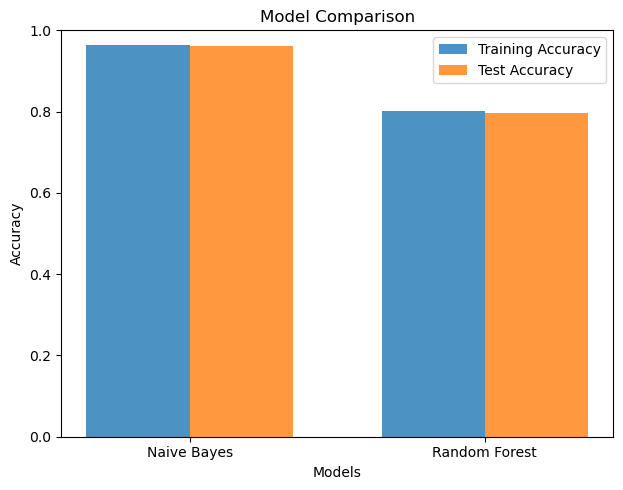


4. KESIMPULAN
----------------------------------------
Naive Bayes memberikan akurasi test yang lebih baik (0.9626 vs 0.7967)


In [43]:
results_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'Random Forest'],
    'Training Accuracy': [nb_train_acc, rf_train_acc],
    'Test Accuracy': [nb_test_acc, rf_test_acc]
})

print("\n3. PERBANDINGAN HASIL")
print("-" * 40)
print(results_df)

# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
models = ['Naive Bayes', 'Random Forest']
train_accs = [nb_train_acc, rf_train_acc]
test_accs = [nb_test_acc, rf_test_acc]

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, train_accs, width, label='Training Accuracy', alpha=0.8)
plt.bar(x + width/2, test_accs, width, label='Test Accuracy', alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.xticks(x, models)
plt.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

print(f"\n4. KESIMPULAN")
print("-" * 40)
if nb_test_acc > rf_test_acc:
    print(f"Naive Bayes memberikan akurasi test yang lebih baik ({nb_test_acc:.4f} vs {rf_test_acc:.4f})")
else:
    print(f"Random Forest memberikan akurasi test yang lebih baik ({rf_test_acc:.4f} vs {nb_test_acc:.4f})")

In [46]:
import pandas as pd
print(f"Naive bayes")
results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': nb_test_preds
})

results_df['correct'] = results_df['actual'] == results_df['predicted']

print(results_df.head())

correct_count = results_df['correct'].sum()
incorrect_count = len(results_df) - correct_count
print(f"Jumlah benar: {correct_count}")
print(f"Jumlah salah: {incorrect_count}")

Naive bayes
   actual  predicted  correct
0       0          0     True
1       0          0     True
2       0          0     True
3       0          0     True
4       0          0     True
Jumlah benar: 4740
Jumlah salah: 184


In [47]:
import pandas as pd
print(f"Random Forest")
results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': rf_test_preds
})

results_df['correct'] = results_df['actual'] == results_df['predicted']

print(results_df.head())

correct_count = results_df['correct'].sum()
incorrect_count = len(results_df) - correct_count

print(f"Jumlah benar: {correct_count}")
print(f"Jumlah salah: {incorrect_count}")

Random Forest
   actual  predicted  correct
0       0          0     True
1       0          0     True
2       0          0     True
3       0          0     True
4       0          0     True
Jumlah benar: 3923
Jumlah salah: 1001


In [48]:
from typing import Sequence, Dict


def confusion_matrix_metrics(
    y_true: Sequence[int],
    y_pred: Sequence[int],
    pos_label: int = 1
) -> Dict[str, int]:

    tp = fp = tn = fn = 0
    for true_label, pred_label in zip(y_true, y_pred):
        if true_label == pos_label and pred_label == pos_label:
            tp += 1
        elif true_label != pos_label and pred_label != pos_label:
            tn += 1
        elif true_label != pos_label and pred_label == pos_label:
            fp += 1
        elif true_label == pos_label and pred_label != pos_label:
            fn += 1
    return {'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn}

nb_metrics = confusion_matrix_metrics(y_true=y_test, y_pred=nb_test_preds)
print('Naive Bayes Confusion Matrix:')
print(nb_metrics)

rf_metrics = confusion_matrix_metrics(y_true=y_test, y_pred=rf_test_preds)
print('Random Forest Confusion Matrix:')
print(rf_metrics)


Naive Bayes Confusion Matrix:
{'TP': 1569, 'TN': 3171, 'FP': 158, 'FN': 26}
Random Forest Confusion Matrix:
{'TP': 596, 'TN': 3327, 'FP': 2, 'FN': 999}
